# Fine Tuning RoBERTa for Toxic Comment Classification (Multi label Text Classification)

## Parameters
### Batch size 32
### Learning Rate - 1e-5
### Loss Function - Focal Tversky Loss



<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution. This configuration is needed if you want to leverage on onboard GPU.

*I have included the code for TPU configuration, but commented it out. If you plan to use the TPU, please comment the GPU execution codes and uncomment the TPU ones to install the packages and define the device.*

In [58]:
#Run this before a fresh training to clear the ouput folder, dont run this if you want to continue from previous training
#!rm -rf /kaggle/input/previous-model/checkpoint_2.pth
#!rm -rf /kaggle/working/*

In [59]:
# Installing the transformers library and additional libraries if looking process

#!pip install upgrade transformers
#!pip install torch

#Code for TPU packages install
# !curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
# !pip install torch==2.1.0

In [60]:
# Importing stock ml libraries
import os
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig, RobertaModel, RobertaTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup

#Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
# device

In [61]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `train.csv` is already downloaded, unzipped and saved in your `data` folder*

* Import the file in a dataframe and give it the headers as per the documentation.
* Taking the values of all the categories and coverting it into a list.
* The list is appened as a new column and other columns are removed

In [62]:
# from google.colab import drive
# drive.mount('/content/drive')
!ls /datasets/sampled_dataset

test.parquet  train.parquet  validation.parquet


In [63]:
# df1_train = pd.read_parquet("/content/drive/MyDrive/TCC_Data/train-00000-of-00002.parquet")
# df2_train = pd.read_parquet("/content/drive/MyDrive/TCC_Data/train-00001-of-00002.parquet")
# df_validation = pd.read_parquet("/content/drive/MyDrive/TCC_Data/validation-00000-of-00001.parquet")
# df_test = pd.read_parquet("/content/drive/MyDrive/TCC_Data/test-00000-of-00001.parquet")

#Get data from dektop
# df1_train = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\train-00000-of-00002.parquet")
# df2_train = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\train-00001-of-00002.parquet")
# df_validation = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\validation-00000-of-00001.parquet")
# df_test = pd.read_parquet(r"C:\Users\gauta\Documents\LJMU Masters\Toxicity\Experiments\Data\test-00000-of-00001.parquet")

#Get data from dektop
df_train = pd.read_parquet(r"/datasets/sampled_dataset/train.parquet")
#df2_train = pd.read_parquet(r"/datasets/toxic_comments_dataset/train-00001-of-00002.parquet")
df_validation = pd.read_parquet(r"/datasets/sampled_dataset/validation.parquet")
df_test = pd.read_parquet(r"/datasets/sampled_dataset/test.parquet")

# def conv_probs_to_labels(df):
#   df['toxicity'] = df['toxicity'].apply(lambda x: 0 if x <0.5 else 1)
#   df['severe_toxicity'] = df['severe_toxicity'].apply(lambda x: 0 if x <0.2 else 1)
#   df['obscene'] = df['obscene'].apply(lambda x: 0 if x <0.5 else 1)
#   df['threat'] = df['threat'].apply(lambda x: 0 if x <0.5 else 1)
#   df['insult'] = df['insult'].apply(lambda x: 0 if x <0.5 else 1)
#   df['identity_attack'] = df['identity_attack'].apply(lambda x: 0 if x <0.5 else 1)
#   df['sexual_explicit'] = df['sexual_explicit'].apply(lambda x: 0 if x <0.5 else 1)
#   return df

# df1_train = conv_probs_to_labels(df1_train)
# df2_train = conv_probs_to_labels(df2_train)
# df_validation = conv_probs_to_labels(df_validation).reset_index()
# df_test = conv_probs_to_labels(df_test).reset_index()

#df_train = pd.concat([df1_train,df2_train],axis=0).reset_index()
# df_train['list'] = df_train[df_train.columns[1:]].values.tolist()
# df_test['list'] = df_test[df_test.columns[1:]].values.tolist()
# df_validation['list'] = df_validation[df_validation.columns[1:]].values.tolist()
# df_train = df_train[['text', 'list']].copy().reset_index()
# df_test = df_test[['text', 'list']].copy().reset_index()
# df_validation = df_validation[['text', 'list']].copy().reset_index()
# df_train = df_train.head(10000)
# df_test = df_test.head(2000)
# df_validation = df_validation.head(2000)

In [64]:
print(df_train.toxicity.sum())
#print(df_train.severe_toxicity.sum())
print(df_train.obscene.sum())
print(df_train.threat.sum())
print(df_train.insult.sum())
print(df_train.identity_attack.sum())
print(df_train.sexual_explicit.sum())

96796
6582
3778
71258
8674
3262


In [65]:
df_train.text.str.len().mean()

133.99267619278277

In [66]:
target_cols = ['toxicity','obscene','threat','insult','identity_attack','sexual_explicit']
df_train[target_cols].values

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of CustomDataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the BERT tokenizer to tokenize the data in the `comment_text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`
---
- *This is the first difference between the distilbert and bert, where the tokenizer generates the token_type_ids in case of Bert*
---
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer)
- `targest` is the list of categories labled as `0` or `1` in the dataframe.
- The *CustomDataset* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [67]:
# Sections of config

# Defining some key variables that will be used later on in the training
#from transformers import BertTokenizer
MAX_LEN = 300
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')
# model_path = '/kaggle/working/checkpoint.pth'
# model_path5 = '/kaggle/working/checkpoint_5.pth'
# model_path4 = '/kaggle/working/checkpoint_4.pth'
# model_path3 = '/kaggle/working/checkpoint_3.pth'
# model_path2 = '/kaggle/working/checkpoint_2.pth'
# model_path1 = '/kaggle/working/checkpoint_1.pth'
#tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")

In [68]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = dataframe[target_cols].values
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            #padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [69]:
# Creating the dataset and dataloader for the neural network

#train_size = 0.8
train_dataset=df_train
test_dataset=df_test
validation_dataset=df_validation.reset_index(drop = True)
train_dataset = train_dataset.reset_index(drop=True)


# print("FULL Dataset: {}".format(new_df.shape))
# print("TRAIN Dataset: {}".format(train_dataset.shape))
# print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(validation_dataset,tokenizer,MAX_LEN)

In [70]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
validation_loader = DataLoader(validation_set, **validation_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`.
 - This network will have the `Bert` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regulariaztion** and **Classification** respectively.
 - In the forward loop, there are 2 output from the `BertModel` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`.
 - Keep note the number of dimensions for `Linear Layer` is **6** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `BertClass` as defined in the dataset.
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

#### Further Reading
- You can refer to my [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials) to get an intuition of Loss Function and Optimizer.
- [Pytorch Documentation for Loss Function](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Pytorch Documentation for Optimizer](https://pytorch.org/docs/stable/optim.html)
- Refer to the links provided on the top of the notebook to read more about `BertModel`.

In [71]:
#Handle class Imbalance with pos_weights
# weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)
num_classes = 7
weights = [len(df_train[i])/(df_train[i].sum() *num_classes) for i in target_cols]
weights = torch.tensor(weights,device = device)
print(weights)

# weights = torch.tensor([0.3,30,5,5,0.5,3.5,10],device = device)
# print(weights)

tensor([0.3047, 4.4808, 7.8065, 0.4139, 3.4001, 9.0413], device='cuda:0',
       dtype=torch.float64)


In [72]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
import torch.nn.functional as F

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('FacebookAI/roberta-base')
        #self.l1 = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        #logits = self.fc(output)
        return output
    
def loss_fn(outputs, targets):
    loss_func = FocalTverskyLoss()
    return loss_func(outputs, targets)

class FocalLoss(torch.nn.Module):
    def __init__(self,
                 gamma: float = 2,
                 reduction: str = "mean",
                 pos_weight: torch.Tensor = None):
        super(FocalLoss, self).__init__()
        self.gamma= gamma
        self.reduction = reduction
        self.pos_weight = pos_weight

    def forward(self, inputs: torch.Tensor,
                targets: torch.Tensor):
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction="none", pos_weight=self.pos_weight
        )
        p_t =  p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss
    
#PyTorch Dince Loss

class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1., class_weights=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.class_weights = weights

    def forward(self, input, target):
        # Flatten inputs
        input_flat = input.view(-1)
        target_flat = target.view(-1)

        # Calculate intersection and union
        intersection = torch.sum(input_flat * target_flat)
        union = torch.sum(input_flat) + torch.sum(target_flat)

        # Calculate Dice coefficient
        dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)

        # Apply class weights if provided
        if self.class_weights is not None:
            class_weights = torch.tensor(self.class_weights).to(input.device)
            dice_loss = 1. - (torch.sum(class_weights * dice_coeff) / torch.sum(class_weights))
        else:
            dice_loss = 1. - dice_coeff

        return dice_loss
    
class FocalTverskyLoss(torch.nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=2, smooth=1.0):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets, alpha=0.7, beta=0.3, gamma=2,smooth=1.0):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        # FN = K.sum(targets * (1-inputs))
        # FP = K.sum((1-targets)*inputs)
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
        loss = torch.mean(FocalTversky)
                       
        return loss
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClass()
optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)
total_steps = len(training_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
model.to(device)

start_epoch = 0
previous_checkpoint = '/kaggle/input/previous-model-checkpoint/checkpoint.pth'
if os.path.exists(previous_checkpoint):
    checkpoint = torch.load(previous_checkpoint)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    start_epoch = epoch+1
    print(f"Loaded checkpoint from epoch {epoch}")
else:
    print("No checkpoint found, starting from scratch.")


Some weights of the model checkpoint at FacebookAI/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


No checkpoint found, starting from scratch.


<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a miniscule loss of 0.022 i.e. the network output is extremely close to the actual output.

In [73]:
def train(epoch,batch_size,weights):
    model.train()

    total_loss, total_accuracy = 0, 0

    total = len(training_loader)
    
    fin_targets=[]
    fin_outputs=[]

    for _,data in enumerate(training_loader, 0):

        step = _+1
        percent = "{0:.10f}".format(100 * (step / float(total)))
        lossp = "{0:.10f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')


        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%1000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        fin_targets.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return fin_outputs, fin_targets, loss

In [74]:
# for epoch in range(EPOCHS):
#     print('Epoch',epoch+1,'of',EPOCHS)
#     train(epoch,8)

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `train.csv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As defined above to get a measure of our models performance we are using the following metrics.
- Accuracy Score
- F1 Micro
- F1 Macro

We are getting amazing results for all these 3 categories just by training the model for 1 Epoch.

In [75]:
def validation(model,data_loader,device,weights):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(data_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets,loss

In [76]:
from collections import defaultdict
history = defaultdict(list)

for epoch in range(start_epoch, EPOCHS):
    print('Epoch',epoch+1,'of',EPOCHS)
    train_op, train_target,train_loss = train(epoch,TRAIN_BATCH_SIZE,weights)
    val_op, val_target,val_loss = validation(model,validation_loader,device,weights)
    train_op = np.array(train_op) >= 0.5
    
    val_op = np.array(val_op) >= 0.5
    train_accuracy = round(metrics.accuracy_score(train_target, train_op),3)
    train_precision_score_micro = round(metrics.precision_score(train_target, train_op, average='micro'),3)
    train_precision_score_macro = round(metrics.precision_score(train_target, train_op, average='macro'),3)
    train_recall_score_micro = round(metrics.recall_score(train_target, train_op, average='micro'),3)
    train_recall_score_macro = round(metrics.recall_score(train_target, train_op, average='macro'),3)
    train_f1_score_micro = round(metrics.f1_score(train_target, train_op, average='micro'),3)
    train_f1_score_macro = round(metrics.f1_score(train_target, train_op, average='macro'),3)
    train_auc_roc_micro = round(metrics.roc_auc_score(train_target, train_op, average='micro'),3)
    train_auc_roc_macro = round(metrics.roc_auc_score(train_target, train_op, average='macro'),3)
    train_clf = metrics.classification_report(train_target, train_op)
    
    val_accuracy = round(metrics.accuracy_score(val_target, val_op),3)
    val_precision_score_micro = round(metrics.precision_score(val_target, val_op, average='micro'),3)
    val_precision_score_macro = round(metrics.precision_score(val_target, val_op, average='macro'),3)
    val_recall_score_micro = round(metrics.recall_score(val_target, val_op, average='micro'),3)
    val_recall_score_macro = round(metrics.recall_score(val_target, val_op, average='macro'),3)
    val_f1_score_micro = round(metrics.f1_score(val_target, val_op, average='micro'),3)
    val_f1_score_macro = round(metrics.f1_score(val_target, val_op, average='macro'),3)
    val_auc_roc_micro = round(metrics.roc_auc_score(val_target, val_op, average='micro'),3)
    val_auc_roc_macro = round(metrics.roc_auc_score(val_target, val_op, average='macro'),3)
    val_clf = metrics.classification_report(val_target,val_op)
    
#     if os.path.exists(model_path):
#         os.remove(model_path)  #Delete the previous file if any
    path = 'Output/checkpoint_' + str(epoch+1)+'.pth'
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, path)
    
    
    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(round(train_loss.item(),4))
    history['train_precision_score_micro'].append(train_precision_score_micro)
    history['train_precision_score_macro'].append(train_precision_score_macro)    
    history['train_recall_score_micro'].append(train_recall_score_micro)
    history['train_recall_score_macro'].append(train_recall_score_macro)
    history['train_f1_score_micro'].append(train_f1_score_micro)
    history['train_f1_score_macro'].append(train_f1_score_macro)
    history['train_rocauc_score_micro'].append(train_auc_roc_micro)
    history['train_rocauc_score_macro'].append(train_auc_roc_macro)
    
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(round(val_loss.item(),4))
    history['val_precision_score_micro'].append(val_precision_score_micro)
    history['val_precision_score_macro'].append(val_precision_score_macro)
    history['val_recall_score_micro'].append(val_recall_score_micro)
    history['val_recall_score_macro'].append(val_recall_score_macro)
    history['val_f1_score_micro'].append(val_f1_score_micro)
    history['val_f1_score_macro'].append(val_f1_score_macro)  
    history['val_rocauc_score_micro'].append(val_auc_roc_micro)
    history['val_rocauc_score_macro'].append(val_auc_roc_macro)
    
    print(f"Train Accuracy Score = {train_accuracy}")
    print(f"Train Precision Score (Micro) = {train_precision_score_micro}")
    print(f"Train Precision Score (Micro) = {train_precision_score_macro}")
    print(f"Train Recall Score (Micro) = {train_recall_score_micro}")
    print(f"Train Recall Score (Macro) = {train_recall_score_macro}")
    print(f"Train F1 Score (Micro) = {train_f1_score_micro}")
    print(f"Train F1 Score (Macro) = {train_f1_score_macro}")
    print(f"Train AUC-ROC Score (Micro) = {train_auc_roc_micro}")
    print(f"Train AUC-ROC Score (Macro) = {train_auc_roc_macro}")
    print("Training Classification Report")
    print("==============================")
    print(train_clf)
    
    print(f"Validation Accuracy Score = {val_accuracy}")
    print(f"Validation Precision Score (Micro) = {val_precision_score_micro}")
    print(f"Validation Precision Score (Micro) = {val_precision_score_macro}")
    print(f"Validation Recall Score (Micro) = {val_recall_score_micro}")
    print(f"Validation Recall Score (Macro) = {val_recall_score_macro}")
    print(f"Validation F1 Score (Micro) = {val_f1_score_micro}")
    print(f"Validation F1 Score (Macro) = {val_f1_score_macro}")
    print(f"Validation AUC-ROC Score (Micro) = {val_auc_roc_micro}")
    print(f"Validation AUC-ROC Score (Macro) = {val_auc_roc_macro}")
    print("Validation Classification Report")
    print("================================")
    print(val_clf)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmo

Epoch 1 of 5
Batch 1/6452 |>...................................................................................................| 0.0154990701% complete, loss=0.0000000000, accuracy=0Epoch: 0, Loss:  0.6431970000267029
Batch 1001/6452 |███████████████>....................................................................................| 15.5145691259% complete, loss=0.0000000000, accuracy=0Epoch: 0, Loss:  0.011511994525790215
Batch 2001/6452 |███████████████████████████████>....................................................................| 31.0136391816% complete, loss=0.0000000000, accuracy=0Epoch: 0, Loss:  0.04317872226238251
Batch 3001/6452 |██████████████████████████████████████████████>.....................................................| 46.5127092374% complete, loss=0.0000000000, accuracy=0Epoch: 0, Loss:  0.015270140022039413
Batch 4001/6452 |██████████████████████████████████████████████████████████████>.....................................| 62.0117792932% complete, loss=0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: Undefine

Train Accuracy Score = 0.724
Train Precision Score (Micro) = 0.821
Train Precision Score (Micro) = 0.288
Train Recall Score (Micro) = 0.73
Train Recall Score (Macro) = 0.275
Train F1 Score (Micro) = 0.773
Train F1 Score (Macro) = 0.275
Train AUC-ROC Score (Micro) = 0.85
Train AUC-ROC Score (Macro) = 0.616
Training Classification Report
              precision    recall  f1-score   support

           0       0.83      0.85      0.84     96796
           1       0.04      0.00      0.00      6582
           2       0.05      0.00      0.00      3778
           3       0.81      0.80      0.80     71258
           4       0.00      0.00      0.00      8674
           5       0.00      0.00      0.00      3262

   micro avg       0.82      0.73      0.77    190350
   macro avg       0.29      0.27      0.27    190350
weighted avg       0.73      0.73      0.73    190350
 samples avg       0.38      0.35      0.36    190350

Validation Accuracy Score = 0.717
Validation Precision Score (Mic

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Batch 1001/6452 |███████████████>....................................................................................| 15.5145691259% complete, loss=0.0000000000, accuracy=0Epoch: 1, Loss:  0.0197629202157259
Batch 2001/6452 |███████████████████████████████>....................................................................| 31.0136391816% complete, loss=0.0000000000, accuracy=0Epoch: 1, Loss:  0.05336786061525345
Batch 3001/6452 |██████████████████████████████████████████████>.....................................................| 46.5127092374% complete, loss=0.0000000000, accuracy=0Epoch: 1, Loss:  0.15686176717281342
Batch 4001/6452 |██████████████████████████████████████████████████████████████>.....................................| 62.0117792932% complete, loss=0.0000000000, accuracy=0Epoch: 1, Loss:  0.05727633461356163
Batch 5001/6452 |█████████████████████████████████████████████████████████████████████████████>......................| 77.5108493490% complete, loss=0.0000000000

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

Train Accuracy Score = 0.734
Train Precision Score (Micro) = 0.841
Train Precision Score (Micro) = 0.28
Train Recall Score (Micro) = 0.729
Train Recall Score (Macro) = 0.274
Train F1 Score (Micro) = 0.781
Train F1 Score (Macro) = 0.277
Train AUC-ROC Score (Micro) = 0.852
Train AUC-ROC Score (Macro) = 0.619
Training Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.85     96796
           1       0.00      0.00      0.00      6582
           2       0.00      0.00      0.00      3778
           3       0.83      0.80      0.81     71258
           4       0.00      0.00      0.00      8674
           5       0.00      0.00      0.00      3262

   micro avg       0.84      0.73      0.78    190350
   macro avg       0.28      0.27      0.28    190350
weighted avg       0.74      0.73      0.74    190350
 samples avg       0.38      0.35      0.36    190350

Validation Accuracy Score = 0.744
Validation Precision Score (Mi

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Batch 1001/6452 |███████████████>....................................................................................| 15.5145691259% complete, loss=0.0000000000, accuracy=0Epoch: 2, Loss:  0.033757634460926056
Batch 2001/6452 |███████████████████████████████>....................................................................| 31.0136391816% complete, loss=0.0000000000, accuracy=0Epoch: 2, Loss:  0.017021963372826576
Batch 3001/6452 |██████████████████████████████████████████████>.....................................................| 46.5127092374% complete, loss=0.0000000000, accuracy=0Epoch: 2, Loss:  0.041552986949682236
Batch 4001/6452 |██████████████████████████████████████████████████████████████>.....................................| 62.0117792932% complete, loss=0.0000000000, accuracy=0Epoch: 2, Loss:  0.04785969853401184
Batch 5001/6452 |█████████████████████████████████████████████████████████████████████████████>......................| 77.5108493490% complete, loss=0.000000

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

Train Accuracy Score = 0.712
Train Precision Score (Micro) = 0.813
Train Precision Score (Micro) = 0.27
Train Recall Score (Micro) = 0.709
Train Recall Score (Macro) = 0.266
Train F1 Score (Micro) = 0.757
Train F1 Score (Macro) = 0.268
Train AUC-ROC Score (Micro) = 0.84
Train AUC-ROC Score (Macro) = 0.612
Training Classification Report
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     96796
           1       0.00      0.00      0.00      6582
           2       0.00      0.00      0.00      3778
           3       0.80      0.78      0.79     71258
           4       0.00      0.00      0.00      8674
           5       0.00      0.00      0.00      3262

   micro avg       0.81      0.71      0.76    190350
   macro avg       0.27      0.27      0.27    190350
weighted avg       0.72      0.71      0.71    190350
 samples avg       0.37      0.34      0.35    190350

Validation Accuracy Score = 0.761
Validation Precision Score (Mic

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Batch 1001/6452 |███████████████>....................................................................................| 15.5145691259% complete, loss=0.0000000000, accuracy=0Epoch: 3, Loss:  0.11852740496397018
Batch 2001/6452 |███████████████████████████████>....................................................................| 31.0136391816% complete, loss=0.0000000000, accuracy=0Epoch: 3, Loss:  0.13328766822814941
Batch 3001/6452 |██████████████████████████████████████████████>.....................................................| 46.5127092374% complete, loss=0.0000000000, accuracy=0Epoch: 3, Loss:  0.04535714164376259
Batch 4001/6452 |██████████████████████████████████████████████████████████████>.....................................| 62.0117792932% complete, loss=0.0000000000, accuracy=0Epoch: 3, Loss:  0.016261903569102287
Batch 5001/6452 |█████████████████████████████████████████████████████████████████████████████>......................| 77.5108493490% complete, loss=0.00000000

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

Train Accuracy Score = 0.707
Train Precision Score (Micro) = 0.835
Train Precision Score (Micro) = 0.278
Train Recall Score (Micro) = 0.654
Train Recall Score (Macro) = 0.246
Train F1 Score (Micro) = 0.734
Train F1 Score (Macro) = 0.261
Train AUC-ROC Score (Micro) = 0.815
Train AUC-ROC Score (Macro) = 0.606
Training Classification Report
              precision    recall  f1-score   support

           0       0.84      0.76      0.80     96796
           1       0.00      0.00      0.00      6582
           2       0.00      0.00      0.00      3778
           3       0.82      0.72      0.77     71258
           4       0.00      0.00      0.00      8674
           5       0.00      0.00      0.00      3262

   micro avg       0.83      0.65      0.73    190350
   macro avg       0.28      0.25      0.26    190350
weighted avg       0.74      0.65      0.69    190350
 samples avg       0.34      0.31      0.32    190350

Validation Accuracy Score = 0.486
Validation Precision Score (M

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Batch 1001/6452 |███████████████>....................................................................................| 15.5145691259% complete, loss=0.0000000000, accuracy=0Epoch: 4, Loss:  0.1341039389371872
Batch 2001/6452 |███████████████████████████████>....................................................................| 31.0136391816% complete, loss=0.0000000000, accuracy=0Epoch: 4, Loss:  0.031050022691488266
Batch 3001/6452 |██████████████████████████████████████████████>.....................................................| 46.5127092374% complete, loss=0.0000000000, accuracy=0Epoch: 4, Loss:  0.07292219996452332
Batch 4001/6452 |██████████████████████████████████████████████████████████████>.....................................| 62.0117792932% complete, loss=0.0000000000, accuracy=0Epoch: 4, Loss:  0.0493941530585289
Batch 5001/6452 |█████████████████████████████████████████████████████████████████████████████>......................| 77.5108493490% complete, loss=0.0000000000

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: 

Train Accuracy Score = 0.675
Train Precision Score (Micro) = 0.845
Train Precision Score (Micro) = 0.279
Train Recall Score (Micro) = 0.547
Train Recall Score (Macro) = 0.205
Train F1 Score (Micro) = 0.664
Train F1 Score (Macro) = 0.236
Train AUC-ROC Score (Micro) = 0.764
Train AUC-ROC Score (Macro) = 0.589
Training Classification Report
              precision    recall  f1-score   support

           0       0.89      0.65      0.75     96796
           1       0.00      0.00      0.00      6582
           2       0.00      0.00      0.00      3778
           3       0.79      0.58      0.67     71258
           4       0.00      0.00      0.00      8674
           5       0.00      0.00      0.00      3262

   micro avg       0.85      0.55      0.66    190350
   macro avg       0.28      0.20      0.24    190350
weighted avg       0.75      0.55      0.63    190350
 samples avg       0.29      0.26      0.27    190350

Validation Accuracy Score = 0.738
Validation Precision Score (M

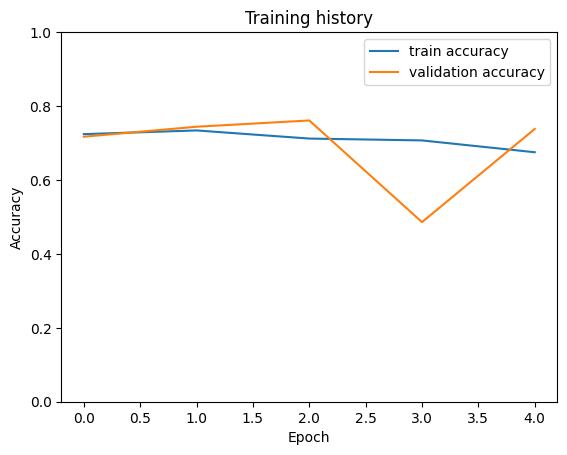

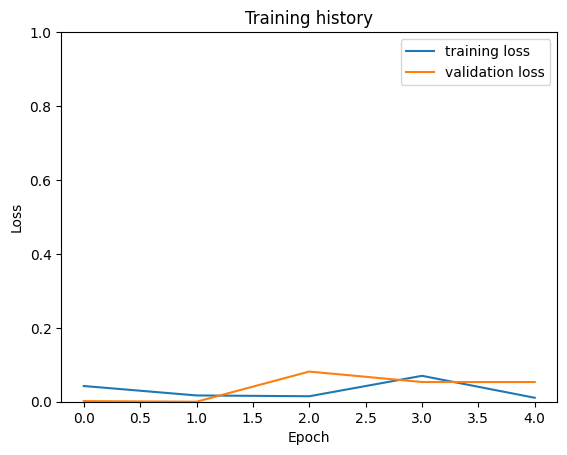

In [77]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.show()

plt.plot(history['train_loss'], label='training loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.show()

In [78]:
history

defaultdict(list,
            {'train_acc': [0.724, 0.734, 0.712, 0.707, 0.675],
             'train_loss': [0.0425, 0.017, 0.0148, 0.0701, 0.0107],
             'train_precision_score_micro': [0.821,
              0.841,
              0.813,
              0.835,
              0.845],
             'train_precision_score_macro': [0.288, 0.28, 0.27, 0.278, 0.279],
             'train_recall_score_micro': [0.73, 0.729, 0.709, 0.654, 0.547],
             'train_recall_score_macro': [0.275, 0.274, 0.266, 0.246, 0.205],
             'train_f1_score_micro': [0.773, 0.781, 0.757, 0.734, 0.664],
             'train_f1_score_macro': [0.275, 0.277, 0.268, 0.261, 0.236],
             'train_rocauc_score_micro': [0.85, 0.852, 0.84, 0.815, 0.764],
             'train_rocauc_score_macro': [0.616, 0.619, 0.612, 0.606, 0.589],
             'val_acc': [0.717, 0.744, 0.761, 0.486, 0.738],
             'val_loss': [0.0017, 0.0, 0.0816, 0.0533, 0.0533],
             'val_precision_score_micro': [0.825, 0.8

In [79]:
test_op,test_target, test_loss = validation(
  model,
  testing_loader,
  device,weights
)

test_op = np.array(test_op) >= 0.5
test_accuracy = metrics.accuracy_score(test_target, test_op)
test_precision_score_micro = metrics.precision_score(test_target, test_op, average='micro')
test_precision_score_macro = metrics.precision_score(test_target, test_op, average='macro')
test_recall_score_micro = metrics.recall_score(test_target, test_op, average='micro')
test_recall_score_macro = metrics.recall_score(test_target, test_op, average='macro')
test_f1_score_micro = metrics.f1_score(test_target, test_op, average='micro')
test_f1_score_macro = metrics.f1_score(test_target, test_op, average='macro')
test_clf = metrics.classification_report(test_target, test_op)
test_roc_auc_micro = metrics.roc_auc_score(test_target,test_op, average='micro')
test_roc_auc_macro = metrics.roc_auc_score(test_target,test_op, average='macro')

print('accuracy',test_accuracy)
print('precision micro',test_precision_score_micro)
print('precision macro',test_precision_score_macro)
print('recall micro',test_recall_score_micro)
print('recall macro',test_recall_score_macro)
print('f1 micro',test_f1_score_micro)
print('f1 macro',test_f1_score_macro)
print('roc_auc micro',test_roc_auc_micro)
print('roc_auc macro',test_roc_auc_macro)
print('Classification Report')
print('=====================')
print(test_clf)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

accuracy 0.7215710834749933
precision micro 0.8064750818479447
precision macro 0.2688221837406946
recall micro 0.64279501304726
recall macro 0.24443731679519062
f1 micro 0.7153920619554693
f1 macro 0.2546783198850279
roc_auc micro 0.8073271547648362
roc_auc macro 0.6026144871198026
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.69      0.77      5242
           1       0.00      0.00      0.00       394
           2       0.00      0.00      0.00       197
           3       0.74      0.78      0.76      3907
           4       0.00      0.00      0.00       445
           5       0.00      0.00      0.00       162

   micro avg       0.81      0.64      0.72     10347
   macro avg       0.27      0.24      0.25     10347
weighted avg       0.72      0.64      0.68     10347
 samples avg       0.30      0.30      0.30     10347



In [80]:
y_pred, y_true,loss = validation(
  model,
  testing_loader,device,weights
)
y_pred = np.array(y_pred) >= 0.5
y_pred

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([[False, False, False, False, False, False],
       [ True, False, False,  True, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [81]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      5242
           1       0.00      0.00      0.00       394
           2       0.00      0.00      0.00       197
           3       0.74      0.78      0.76      3907
           4       0.00      0.00      0.00       445
           5       0.00      0.00      0.00       162

   micro avg       0.81      0.64      0.72     10347
   macro avg       0.27      0.24      0.25     10347
weighted avg       0.72      0.64      0.68     10347
 samples avg       0.30      0.30      0.30     10347



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
#from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix(np.array(y_true).argmax(axis=1),np.array(y_pred).argmax(axis=1))

array([[11041,     0,     0,     0,     0,     0],
       [   13,     0,     0,     0,     0,     0],
       [    6,     0,     0,     0,     0,     0],
       [   74,     0,     0,     0,     0,     0],
       [   30,     0,     0,     0,     0,     0],
       [   13,     0,     0,     0,     0,     0]])

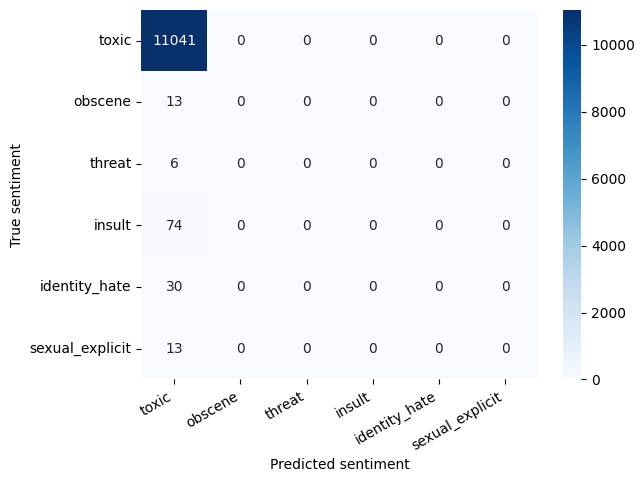

In [83]:
import seaborn as sns
class_name = ['toxic','obscene','threat','insult','identity_hate','sexual_explicit']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(np.array(y_true).argmax(axis=1),np.array(y_pred).argmax(axis=1))
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [84]:
#Prediction

In [85]:
class_name = ['toxic','obscene','threat','insult','identity_hate','sexual_explicit']

review_text = "You criminal.. I will k*ll you"

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=300,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
token_type_ids = encoded_review['token_type_ids'].to(device)
output = model(input_ids, attention_mask,token_type_ids)
print(output)
print(output.view(-1))
print(sigmoid(output.cpu().detach()))
output = sigmoid(output.cpu().detach())>0.5
print(output)
output = list(output)

print(f'Review text: {review_text}')
print(f'Sentiment  : {output}')

op = {
    'toxic':output[0][0],
    #'severe_toxic':output[0][1],
    'obscene':output[0][1],
    'threat':output[0][2],
    'insult':output[0][3],
    'identity_hate':output[0][4],
    'sexual_explicit':output[0][5]
}
op

tensor([[ 12.9058, -17.7037, -17.7337,  12.4859, -17.8065, -17.8349]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([ 12.9058, -17.7037, -17.7337,  12.4859, -17.8065, -17.8349],
       device='cuda:0', grad_fn=<ViewBackward0>)
tensor([[1.0000e+00, 2.0482e-08, 1.9876e-08, 1.0000e+00, 1.8481e-08, 1.7965e-08]])
tensor([[ True, False, False,  True, False, False]])
Review text: You criminal.. I will k*ll you
Sentiment  : [tensor([ True, False, False,  True, False, False])]


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2323: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'toxic': tensor(True),
 'obscene': tensor(False),
 'threat': tensor(False),
 'insult': tensor(True),
 'identity_hate': tensor(False),
 'sexual_explicit': tensor(False)}

In [86]:
print(alpha)

NameError: name 'alpha' is not defined

<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

Please remember that a trained neural network is only useful when used in actual inference after its training.

In the lifecycle of an ML projects this is only half the job done. We will leave the inference of these models for some other day.